# Feature Engineering and Training our Model
We'll first setup the glue context in which we can read the glue data catalog, as well as setup some constants.

In [ ]:
import sys
from awsglue.transforms import *
from awsglue.utils import getResolvedOptions
from pyspark.context import SparkContext
from awsglue.context import GlueContext
from awsglue.job import Job

glueContext = GlueContext(SparkContext.getOrCreate())

database_name = '2019reinventWorkshop'
canonical_table_name = "canonical"

## Reading the Data using the Catalog
Using the glue context, we can read in the data.  This is done by using the glue data catalog and looking up the data

Here we can see there are ***500 million*** records

In [2]:
taxi_data = glueContext.create_dynamic_frame.from_catalog(database=database_name, table_name=canonical_table_name)
print("2018/2019 Taxi Data Count: ", taxi_data.count())
taxi_data.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

2018/2019 Taxi Data Count:  452091095
root
|-- pickup_datetime: timestamp
|-- dropoff_datetime: timestamp
|-- pulocationid: long
|-- dolocationid: long
|-- type: string
|-- vendorid: string

### Caching in Spark
We'll use the taxi dataframe a bit repeatitively, so we'll cache it ehre and show some sample records.

In [3]:
df = taxi_data.toDF().cache()
df.show(10, False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+-------------------+------------+------------+-----+--------+
|pickup_datetime    |dropoff_datetime   |pulocationid|dolocationid|type |vendorid|
+-------------------+-------------------+------------+------------+-----+--------+
|null               |null               |null        |null        |green|null    |
|2018-01-01 00:18:50|2018-01-01 00:24:39|null        |null        |green|null    |
|2018-01-01 00:30:26|2018-01-01 00:46:42|null        |null        |green|null    |
|2018-01-01 00:07:25|2018-01-01 00:19:45|null        |null        |green|null    |
|2018-01-01 00:32:40|2018-01-01 00:33:41|null        |null        |green|null    |
|2018-01-01 00:32:40|2018-01-01 00:33:41|null        |null        |green|null    |
|2018-01-01 00:38:35|2018-01-01 01:08:50|null        |null        |green|null    |
|2018-01-01 00:18:41|2018-01-01 00:28:22|null        |null        |green|null    |
|2018-01-01 00:38:02|2018-01-01 00:55:02|null        |null        |green|null    |
|201

### Removing invalid dates
When we originally looked at this data, we saw that it had a lot of bad data in it, and timestamps that were outside the range that are valid.  Let's ensure we are only using the valid records when aggregating and creating our time series.

In [4]:
from pyspark.sql.functions import to_date, lit
from pyspark.sql.types import TimestampType

dates = ("2018-01-01",  "2019-07-01")
date_from, date_to = [to_date(lit(s)).cast(TimestampType()) for s in dates]

df  = df.where((df.pickup_datetime > date_from) & (df.pickup_datetime < date_to))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

We need to restructure this so that each time is a single row, and the time series values are in the series, followed by the numerical and categorical features


## Creating our time series (from individual records)
Right now they are individual records down to the second level, we'll create a record at the day level for each record and then count/aggregate over those.

Let's start by adding a ts_resampled column

In [5]:
from pyspark.sql.functions import col, max as max_, min as min_

## day = seconds*minutes*hours
unit = 60 * 60 * 24
epoch = (col("pickup_datetime").cast("bigint") / unit).cast("bigint") * unit

with_epoch = df.withColumn("epoch", epoch)

min_epoch, max_epoch = with_epoch.select(min_("epoch"), max_("epoch")).first()

# Reference range 
ref = spark.range(
    min_epoch, max_epoch + 1, unit
).toDF("epoch")

resampled_df = (ref
    .join(with_epoch, "epoch", "left")
    .orderBy("epoch")
    .withColumn("ts_resampled", col("epoch").cast("timestamp")))

resampled_df.cache()

resampled_df.show(10, False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+-------------------+-------------------+------------+------------+------+--------+-------------------+
|epoch     |pickup_datetime    |dropoff_datetime   |pulocationid|dolocationid|type  |vendorid|ts_resampled       |
+----------+-------------------+-------------------+------------+------------+------+--------+-------------------+
|1514764800|2018-01-01 00:21:05|2018-01-01 00:24:23|null        |null        |yellow|null    |2018-01-01 00:00:00|
|1514764800|2018-01-01 00:44:55|2018-01-01 01:03:05|null        |null        |yellow|null    |2018-01-01 00:00:00|
|1514764800|2018-01-01 00:08:26|2018-01-01 00:14:21|null        |null        |yellow|null    |2018-01-01 00:00:00|
|1514764800|2018-01-01 00:20:22|2018-01-01 00:52:51|null        |null        |yellow|null    |2018-01-01 00:00:00|
|1514764800|2018-01-01 00:09:18|2018-01-01 00:27:06|null        |null        |yellow|null    |2018-01-01 00:00:00|
|1514764800|2018-01-01 00:29:29|2018-01-01 00:32:48|null        |null        |ye

### Creating our time series data
You can see now that we are resampling per day the resample column, in which we can now aggregate across.

In [6]:
from pyspark.sql import functions as func

count_per_day_resamples = resampled_df.groupBy(["ts_resampled", "type"]).count()
count_per_day_resamples.cache()
count_per_day_resamples.show(10, False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+------+------+
|ts_resampled       |type  |count |
+-------------------+------+------+
|2018-11-11 00:00:00|yellow|257698|
|2019-02-22 00:00:00|fhv   |65041 |
|2019-03-07 00:00:00|yellow|291098|
|2018-11-28 00:00:00|green |22899 |
|2018-03-15 00:00:00|yellow|348198|
|2018-11-20 00:00:00|yellow|278900|
|2018-12-30 00:00:00|fhv   |683406|
|2019-04-10 00:00:00|green |17165 |
|2018-03-05 00:00:00|yellow|290631|
|2018-02-21 00:00:00|green |25651 |
+-------------------+------+------+
only showing top 10 rows

### We restructure it so that each taxi type is it's own column in the dataset.

In [7]:
time_series_df = count_per_day_resamples.groupBy(["ts_resampled"])\
.pivot('type')\
.sum("count").cache()

time_series_df.show(10,False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+------+-----+------+
|ts_resampled       |fhv   |green|yellow|
+-------------------+------+-----+------+
|2019-06-18 00:00:00|69383 |15545|242304|
|2019-03-21 00:00:00|47855 |20326|274057|
|2018-09-09 00:00:00|794608|20365|256918|
|2018-12-13 00:00:00|822745|24585|308411|
|2018-08-16 00:00:00|717045|22113|277677|
|2018-09-20 00:00:00|723583|23378|298630|
|2018-01-31 00:00:00|640887|26667|319256|
|2018-07-13 00:00:00|753204|24518|277145|
|2018-05-15 00:00:00|689620|25458|309023|
|2018-12-24 00:00:00|640740|19314|185895|
+-------------------+------+-----+------+
only showing top 10 rows

## Local Data Manipulation
Now that we an aggregated time series that is much smaller -- let's send this back to the local python environment off the spark cluster on Glue.

In [8]:
%%spark -o time_series_df

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### We are in the local panda/python environment now


In [9]:
%%local
import pandas as pd
print(time_series_df.dtypes)

time_series_df = time_series_df.set_index('ts_resampled', drop=True)
time_series_df = time_series_df.sort_index()

time_series_df.head()


ts_resampled    datetime64[ns]
fhv                      int64
green                    int64
yellow                   int64
dtype: object


Output()

### We'll create the training window next,  We are going to predict the next week

In [10]:
%%local

## number of time-steps that the model is trained to predict
prediction_length = 14

n_weeks = 4
end_training = time_series_df.index[-n_weeks*prediction_length]
print('end training time', end_training)

time_series = []
for ts in time_series_df.columns:
    time_series.append(time_series_df[ts])
    
time_series_training = []
for ts in time_series_df.columns:
    time_series_training.append(time_series_df.loc[:end_training][ts])

end training time 2019-05-06 00:00:00


### We'll install matplotlib in the local kernel to visualize this.

In [11]:
%%local
!pip install matplotlib > /dev/null

### Visualizing the training and test dataset:
In this next cell, we can see how the training and test datasets are split up.  Since this is time series, we don't do a random split, instead, we look at how far in the future we are predicting and using that a a knob.

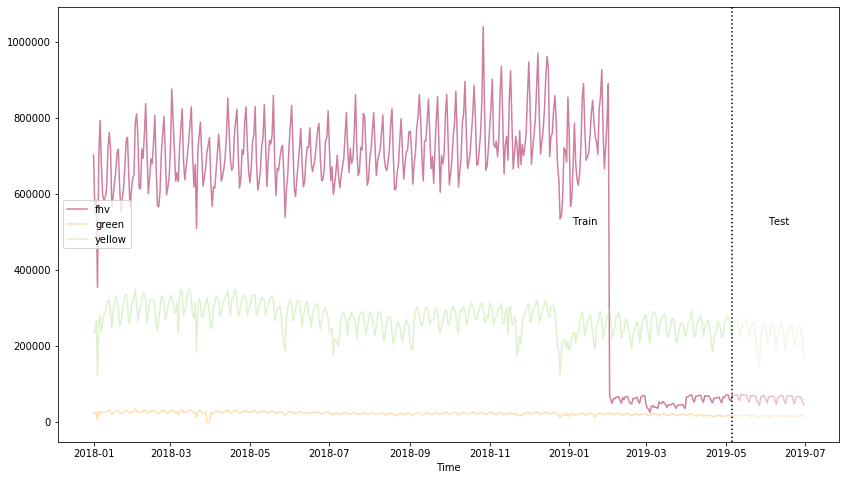

In [12]:
%%local
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
#cols_float = time_series_df.drop(['pulocationid', 'dolocationid'], axis=1).columns
cols_float = time_series_df.columns
cmap = matplotlib.cm.get_cmap('Spectral')
colors = cmap(np.arange(0,len(cols_float))/len(cols_float))


plt.figure(figsize=[14,8]);
for c in range(len(cols_float)):
    plt.plot(time_series_df.loc[:end_training][cols_float[c]], alpha=0.5, color=colors[c], label=cols_float[c]);  
plt.legend(loc='center left');
for c in range(len(cols_float)):
    plt.plot(time_series_df.loc[end_training:][cols_float[c]], alpha=0.25, color=colors[c], label=None);
plt.axvline(x=end_training, color='k', linestyle=':');
plt.text(time_series_df.index[int((time_series_df.shape[0]-n_weeks*prediction_length)*0.75)], time_series_df.max().max()/2, 'Train');
plt.text(time_series_df.index[time_series_df.shape[0]-int(n_weeks*prediction_length/2)], time_series_df.max().max()/2, 'Test');
plt.xlabel('Time');
plt.show()

## Cleaning our Time Series
FHV still has the issue -- the time series drops when the law is in place.

we still need to pull in the FHV HV dataset starting in Feb.  This represents the rideshare apps going to a difference licence type under the NYC TLC.

In [13]:
## we are running back on spark now
fhvhv_data = glueContext.create_dynamic_frame.from_catalog(database=database_name, table_name="fhvhv")
fhvhv_df = fhvhv_data.toDF().cache()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Let's filter the time range just in case we have additional bad records here.

In [14]:
fhvhv_df = fhvhv_df.where((fhvhv_df.pickup_datetime > date_from) & (fhvhv_df.pickup_datetime < date_to)).cache()

from pyspark.sql.functions import to_timestamp
fhvhv_df = fhvhv_df.withColumn("pickup_datetime", to_timestamp("pickup_datetime", "yyyy-MM-dd HH:mm:ss"))
fhvhv_df.show(5, False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------------+--------------------+-------------------+-------------------+------------+------------+-------+
|hvfhs_license_num|dispatching_base_num|pickup_datetime    |dropoff_datetime   |pulocationid|dolocationid|sr_flag|
+-----------------+--------------------+-------------------+-------------------+------------+------------+-------+
|HV0003           |B02867              |2019-02-01 00:05:18|2019-02-01 00:14:57|245         |251         |null   |
|HV0003           |B02879              |2019-02-01 00:41:29|2019-02-01 00:49:39|216         |197         |null   |
|HV0005           |B02510              |2019-02-01 00:51:34|2019-02-01 01:28:29|261         |234         |null   |
|HV0005           |B02510              |2019-02-01 00:03:51|2019-02-01 00:07:16|87          |87          |null   |
|HV0005           |B02510              |2019-02-01 00:09:44|2019-02-01 00:39:56|87          |198         |null   |
+-----------------+--------------------+-------------------+-------------------+

### Let's first create our rollup column for the time resampling

In [15]:
from pyspark.sql.functions import col, max as max_, min as min_

## day = seconds*minutes*hours
unit = 60 * 60 * 24

epoch = (col("pickup_datetime").cast("bigint") / unit).cast("bigint") * unit

with_epoch = fhvhv_df.withColumn("epoch", epoch)

min_epoch, max_epoch = with_epoch.select(min_("epoch"), max_("epoch")).first()

ref = spark.range(
    min_epoch, max_epoch + 1, unit
).toDF("epoch")

resampled_fhvhv_df = (ref
    .join(with_epoch, "epoch", "left")
    .orderBy("epoch")
    .withColumn("ts_resampled", col("epoch").cast("timestamp")))

resampled_fhvhv_df = resampled_fhvhv_df.cache()

resampled_fhvhv_df.show(10, False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+-----------------+--------------------+-------------------+-------------------+------------+------------+-------+-------------------+
|epoch     |hvfhs_license_num|dispatching_base_num|pickup_datetime    |dropoff_datetime   |pulocationid|dolocationid|sr_flag|ts_resampled       |
+----------+-----------------+--------------------+-------------------+-------------------+------------+------------+-------+-------------------+
|1548979200|HV0003           |B02867              |2019-02-01 00:05:18|2019-02-01 00:14:57|245         |251         |null   |2019-02-01 00:00:00|
|1548979200|HV0003           |B02879              |2019-02-01 00:41:29|2019-02-01 00:49:39|216         |197         |null   |2019-02-01 00:00:00|
|1548979200|HV0005           |B02510              |2019-02-01 00:51:34|2019-02-01 01:28:29|261         |234         |null   |2019-02-01 00:00:00|
|1548979200|HV0005           |B02510              |2019-02-01 00:03:51|2019-02-01 00:07:16|87          |87          |null   

### Create our Time Series now

In [16]:
from pyspark.sql import functions as func
count_per_day_resamples = resampled_fhvhv_df.groupBy(["ts_resampled"]).count()
count_per_day_resamples.cache()
count_per_day_resamples.show(10, False)
fhvhv_timeseries_df = count_per_day_resamples

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+------+
|ts_resampled       |count |
+-------------------+------+
|2019-06-18 00:00:00|692171|
|2019-03-21 00:00:00|809819|
|2019-05-03 00:00:00|815626|
|2019-04-25 00:00:00|689853|
|2019-05-12 00:00:00|857727|
|2019-03-10 00:00:00|812902|
|2019-04-30 00:00:00|655312|
|2019-06-26 00:00:00|663954|
|2019-06-06 00:00:00|682378|
|2019-02-06 00:00:00|663516|
+-------------------+------+
only showing top 10 rows

---

Now we bring this new time series back locally to join it w/ the existing one.

In [19]:
%%spark -o fhvhv_timeseries_df

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### We rename the count column to be fhvhv so we can join it w/ the other dataframe

In [20]:
%%local
fhvhv_timeseries_df = fhvhv_timeseries_df.rename(columns={"count": "fhvhv"})
fhvhv_timeseries_df = fhvhv_timeseries_df.set_index('ts_resampled', drop=True)

## Visualizing all the time series data
When we look at the FHVHV dataset starting in Feb 1st, you can see the time series looks normal and there isn't a giant drop in the dataset on that day.

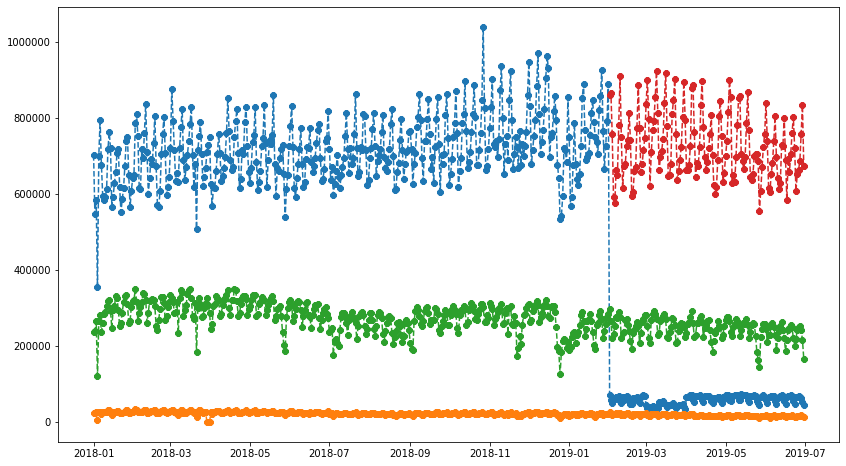

In [21]:
%%local
plt.figure(figsize=[14,8]);
plt.plot(time_series_df.join(fhvhv_timeseries_df), marker='8', linestyle='--')

## But now we need to combine the FHV and FHVHV dataset
Let's create a new dataset and call it full_fhv meaning both for-hire-vehicles and for-hire-vehicles high volume.

In [22]:
%%local
full_timeseries = time_series_df.join(fhvhv_timeseries_df)
full_timeseries = full_timeseries.fillna(0)
full_timeseries['full_fhv'] = full_timeseries['fhv'] + full_timeseries['fhvhv']
full_timeseries = full_timeseries.drop(['fhv', 'fhvhv'], axis=1)

full_timeseries = full_timeseries.fillna(0)

### Visualizing the joined dataset

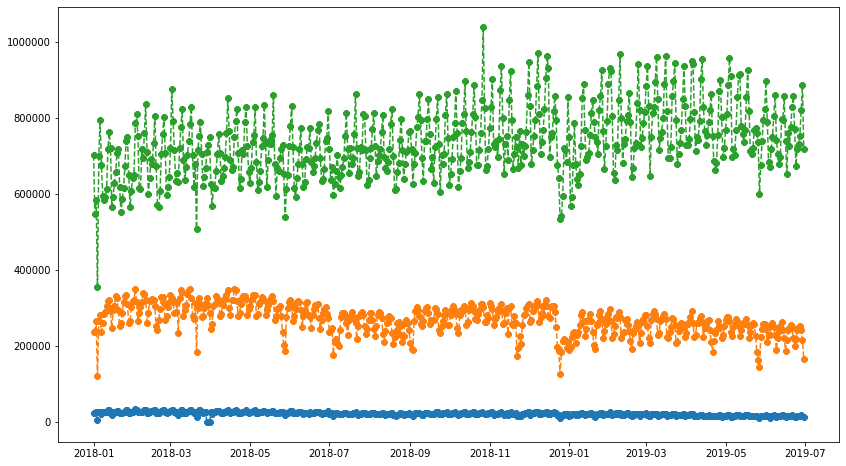

In [23]:
%%local
plt.figure(figsize=[14,8]);
plt.plot(full_timeseries, marker='8', linestyle='--')

In [24]:
%%local
import json
import boto3

end_training = full_timeseries.index[-n_weeks*prediction_length]
print('end training time', end_training)

time_series = []
for ts in full_timeseries.columns:
    time_series.append(full_timeseries[ts])
    
time_series_training = []
for ts in full_timeseries.columns:
    time_series_training.append(full_timeseries.loc[:end_training][ts])

import sagemaker
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()

key_prefix = '2019workshop-deepar/'

s3_client = boto3.client('s3')
def series_to_obj(ts, cat=None):
    obj = {"start": str(ts.index[0]), "target": list(ts)}
    if cat:
        obj["cat"] = cat
    return obj

def series_to_jsonline(ts, cat=None):
    return json.dumps(series_to_obj(ts, cat))

encoding = "utf-8"
data = ''

for ts in time_series_training:
    data = data + series_to_jsonline(ts)
    data = data + '\n'
    
s3_client.put_object(Body=data.encode(encoding), Bucket=bucket, Key=key_prefix + 'data/train/train.json')
    

data = ''
for ts in time_series:
    data = data + series_to_jsonline(ts)
    data = data + '\n'

s3_client.put_object(Body=data.encode(encoding), Bucket=bucket, Key=key_prefix + 'data/test/test.json')


end training time 2019-05-06 00:00:00


{'ResponseMetadata': {'RequestId': 'BB23D068EDEC81C2',
  'HostId': 'TmqPKIVqy0/Qj8nSq6Dk58RBfNdM41nYJiYOdm6EwNp45O1sIocHJDY7TN7IiBXn/RCEofVnDGQ=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'TmqPKIVqy0/Qj8nSq6Dk58RBfNdM41nYJiYOdm6EwNp45O1sIocHJDY7TN7IiBXn/RCEofVnDGQ=',
   'x-amz-request-id': 'BB23D068EDEC81C2',
   'date': 'Sat, 30 Nov 2019 04:49:09 GMT',
   'etag': '"3d0c723b9f128d637f003391b7546c16"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"3d0c723b9f128d637f003391b7546c16"'}

### Setting our data and output locations

In [25]:
%%local
import boto3
import s3fs
import sagemaker
from sagemaker import get_execution_role
sagemaker_session = sagemaker.Session()
role = get_execution_role()

s3_data_path = "{}/{}data".format(bucket, key_prefix)
s3_output_path = "{}/{}output".format(bucket, key_prefix)

### Setting up the DeepAR Algorithm settings

In [26]:
%%local

region = sagemaker_session.boto_region_name
image_name = sagemaker.amazon.amazon_estimator.get_image_uri(region, "forecasting-deepar", "latest")

estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c4.2xlarge',
    base_job_name='DeepAR-forecast-taxidata',
    output_path="s3://" + s3_output_path
)

## context_length = The number of time-points that the model gets to see before making the prediction.
context_length = 14

hyperparameters = {
    "time_freq": "D",
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
    "num_cells": "40",
    "num_layers": "3",
    "likelihood": "gaussian",
    "epochs": "100",
    "mini_batch_size": "32",
    "learning_rate": "0.001",
    "dropout_rate": "0.05",
    "early_stopping_patience": "10"
}

estimator.set_hyperparameters(**hyperparameters)

### Kicking off the training

In [27]:
%%local

estimator.fit(inputs={
    "train": "s3://{}/train/".format(s3_data_path),
    "test": "s3://{}/test/".format(s3_data_path)
})

2019-11-30 04:49:13 Starting - Starting the training job...
2019-11-30 04:49:14 Starting - Launching requested ML instances......
2019-11-30 04:50:17 Starting - Preparing the instances for training...
2019-11-30 04:51:02 Downloading - Downloading input data...
2019-11-30 04:51:39 Training - Training image download completed. Training in progress..Arguments: train
[11/30/2019 04:51:42 INFO 140586766321472] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience': u'

[11/30/2019 04:51:51 INFO 140586766321472] Epoch[21] Batch[5] avg_epoch_loss=11.049412
[11/30/2019 04:51:51 INFO 140586766321472] #quality_metric: host=algo-1, epoch=21, batch=5 train loss <loss>=11.0494124095
[11/30/2019 04:51:51 INFO 140586766321472] Epoch[21] Batch [5]#011Speed: 1065.51 samples/sec#011loss=11.049412
[11/30/2019 04:51:51 INFO 140586766321472] processed a total of 320 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 342.3631191253662, "sum": 342.3631191253662, "min": 342.3631191253662}}, "EndTime": 1575089511.361838, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1575089511.019057}

[11/30/2019 04:51:51 INFO 140586766321472] #throughput_metric: host=algo-1, train throughput=934.350225064 records/second
[11/30/2019 04:51:51 INFO 140586766321472] #progress_metric: host=algo-1, completed 22 % of epochs
[11/30/2019 04:51:51 INFO 140586766321472] #quality_metric: host=algo-1, epoch=21, train loss <loss>=1


2019-11-30 04:52:06 Uploading - Uploading generated training model
2019-11-30 04:52:06 Completed - Training job completed
Training seconds: 64
Billable seconds: 64


## DeepAR Deep Dive

While the training is happening, Let’s elaborate on the DeepAR model's architecture by walking through an example. When interested in quantifying the confidence of the estimates produced, then it's probabilistic forecasts that are wanted. The data we’re working with is real-valued, so let’s opt for the Gaussian likelihood:
$$\ell(y_t|\mu_t,\sigma_t)=\frac{1}{\sqrt{2\pi\sigma^2}}\exp{\frac{-(y_t-\mu_t)^2}{2\sigma^2}}.$$

$\theta$ represents the `parameters of the likelihood`. In the case of Gaussian, $\theta_t$ will represent the mean and standard deviation:  $$\theta_t = \{\mu_{t},\sigma_{t}\}.$$

The neural network’s last hidden layer results in $h_{d,t}$. This $h_{d,t}$ will undergo 1 activation function per likelihood parameter. For example, for the Gaussian likelihood, $h_{d,t}$ is transformed by an affine activation function to get the mean:
$$\mu_{t} = w_{\mu}^T h_{d,t} + b_{\mu},$$
and then $h$ is transformed by a softplus activation to get the standard deviation:
$$\sigma_t = \log\left(1 + \exp(w_{\sigma}^T h_{d,t} + b_{\sigma})\right).$$

The `activation parameters` are the $w_{\mu},b_{\mu},w_{\sigma},b_{\sigma}$ parameters within the activation functions. The NN is trained to learn the fixed constants of the activation parameters.  Since the $h_{d,t}$ output  vary given each time-step's input, this still allows the likelihood parameters to vary over time, and therefore capture dynamic behaviors in the time-series data.

![DeepAR Training](images/deepar_training.png)

From the above diagram, the <span style="color:green">green</span> input at each time-step is the data point preceding the current time-step’s data, as well as the previous network’s output. For simplicity, on this diagram we aren’t showing covariates which would also be input.

The LSTM layers are shown in <span style="color:red">red</span>, and the final hidden layer produces the $h_{d,t}$ value, which we saw in the previous slide will undergo an activation function for each parameter of the specified likelihood. To learn the activation function parameters, the NN takes the $h_{d,t}$ at time $t$ and the data up until time $t$, and performs Stochastic Gradient Descent (SGD) to yield the activation parameters which maximize the likelihood at time $t$. The <span style="color:blue">blue</span> output layer uses the SGD-optimized activation functions to output the maximum likelihood parameters.

This is how DeepAR trains its model to your data input. Now we want to DeepAR to give us probabilistic forecasts for the next time-step.

![DeepAR Forecast](images/deepar_forecast.png)

The <span style="color:magenta">pink</span> line marks our current point in time, divides our training data from data not yet seen. For the first input, it can use the data point of the current time. The input will be processed by the trained LSTM layers, and subsequently get activated by the optimized activation functions to output the maximum-likelihood theta parameters at time $t+1$. 

Now that DeepAR has completed the likelihood with its parameter estimates, DeepAR can simulate `Monte Carlo (MC) samples` from this likelihood and produce an empirical distribution for the predicted datapoint - the probabilistic forecasts shown in <span style="color:purple">purple</span>. The MC samples produced at time $t+1$ are used as input for time $t+2$, etc, until the end of the prediction horizon. In the interactive plots below, we'll see how Monte Carlo samples are able to provide us a confidence interval about the point estimate.


In [28]:
%%local
class DeepARPredictor(sagemaker.predictor.RealTimePredictor):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, content_type=sagemaker.content_types.CONTENT_TYPE_JSON, **kwargs)
        
    def predict(self, ts, cat=None, dynamic_feat=None, 
                num_samples=100, return_samples=False, quantiles=["0.1", "0.5", "0.9"]):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.
        
        ts -- `pandas.Series` object, the time series to predict
        cat -- integer, the group associated to the time series (default: None)
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        return_samples -- boolean indicating whether to include samples in the response (default: False)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])
        
        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_time = ts.index[-1] + 1
        quantiles = [str(q) for q in quantiles]
        req = self.__encode_request(ts, cat, dynamic_feat, num_samples, return_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, ts.index.freq, prediction_time, return_samples)
    
    def __encode_request(self, ts, cat, dynamic_feat, num_samples, return_samples, quantiles):
        instance = series_to_dict(ts, cat if cat is not None else None, dynamic_feat if dynamic_feat else None)

        configuration = {
            "num_samples": num_samples,
            "output_types": ["quantiles", "samples"] if return_samples else ["quantiles"],
            "quantiles": quantiles
        }
        
        http_request_data = {
            "instances": [instance],
            "configuration": configuration
        }
        
        return json.dumps(http_request_data).encode('utf-8')
    
    def __decode_response(self, response, freq, prediction_time, return_samples):
        # we only sent one time series so we only receive one in return
        # however, if possible one will pass multiple time series as predictions will then be faster
        predictions = json.loads(response.decode('utf-8'))['predictions'][0]
        prediction_length = len(next(iter(predictions['quantiles'].values())))
        prediction_index = pd.DatetimeIndex(start=prediction_time, freq=freq, periods=prediction_length)        
        if return_samples:
            dict_of_samples = {'sample_' + str(i): s for i, s in enumerate(predictions['samples'])}
        else:
            dict_of_samples = {}
        return pd.DataFrame(data={**predictions['quantiles'], **dict_of_samples}, index=prediction_index)

    def set_frequency(self, freq):
        self.freq = freq
        
def encode_target(ts):
    return [x if np.isfinite(x) else "NaN" for x in ts]        

def series_to_dict(ts, cat=None, dynamic_feat=None):
    """Given a pandas.Series object, returns a dictionary encoding the time series.

    ts -- a pands.Series object with the target time series
    cat -- an integer indicating the time series category

    Return value: a dictionary
    """
    obj = {"start": str(ts.index[0]), "target": encode_target(ts)}
    if cat is not None:
        obj["cat"] = cat
    if dynamic_feat is not None:
        obj["dynamic_feat"] = dynamic_feat        
    return obj

## Deploying a realtime predictor

### Next we will deploy a predictor,  this may take a few minutes

In [29]:
%%local
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    predictor_cls=DeepARPredictor
)


----------------------------------------------------------------------------------------------------------------!

## Running Predictions on the Endpoint

In [30]:
%%local
ABB = full_timeseries.asfreq('d')
print('Green Rides:')
print(predictor.predict(ts=ABB.loc[end_training:, 'green'], quantiles=[0.10, 0.5, 0.90], num_samples=100).head())
print('\nYellow Rides:')
print(predictor.predict(ts=ABB.loc[end_training:, 'yellow'], quantiles=[0.10, 0.5, 0.90], num_samples=100).head())
print('\nFHV Rides:')
print(predictor.predict(ts=ABB.loc[end_training:, 'full_fhv'], quantiles=[0.10, 0.5, 0.90], num_samples=100).head())

Green Rides:
                     0.1           0.5           0.9
2019-07-01   9908.235352  13962.511719  17695.085938
2019-07-02  11526.123047  15104.618164  18052.578125
2019-07-03  11840.423828  15429.480469  19371.992188
2019-07-04  11753.914062  16678.773438  21083.078125
2019-07-05  14201.886719  17475.248047  21384.064453

Yellow Rides:
                      0.1            0.5           0.9
2019-07-01  162041.203125  194994.218750  225315.56250
2019-07-02  190669.281250  215316.671875  247135.09375
2019-07-03  216440.187500  244561.296875  265086.09375
2019-07-04  236035.609375  263231.531250  288104.84375
2019-07-05  241759.078125  264561.218750  295605.78125

FHV Rides:
                    0.1        0.5          0.9
2019-07-01  599792.5625  672683.00  763733.1875
2019-07-02  606547.4375  691632.75  766185.0000
2019-07-03  669395.2500  734418.50  836748.5000
2019-07-04  733438.4375  796031.75  877697.0000
2019-07-05  792988.3750  871114.00  948283.3750


### Let's see the plot results

In [31]:
%%local
import matplotlib
import matplotlib.pyplot as plt

def plot(
    predictor, 
    target_ts, 
    cat=None, 
    dynamic_feat=None, 
    forecast_date=end_training, 
    show_samples=False, 
    plot_history=7 * 12,
    confidence=80,
    num_samples=100,
    draw_color='blue'
):
    print("Calling endpoint to generate {} predictions starting from {} ...".format(target_ts.name, str(forecast_date)))
    assert(confidence > 50 and confidence < 100)
    low_quantile = 0.5 - confidence * 0.005
    up_quantile = confidence * 0.005 + 0.5
        
    # we first construct the argument to call our model
    args = {
        "ts": target_ts[:forecast_date],
        "return_samples": show_samples,
        "quantiles": [low_quantile, 0.5, up_quantile],
        "num_samples": num_samples
    }


    if dynamic_feat is not None:
        args["dynamic_feat"] = dynamic_feat
        fig = plt.figure(figsize=(20, 6))
        ax = plt.subplot(2, 1, 1)
    else:
        fig = plt.figure(figsize=(20, 3))
        ax = plt.subplot(1,1,1)
    
    if cat is not None:
        args["cat"] = cat
        ax.text(0.9, 0.9, 'cat = {}'.format(cat), transform=ax.transAxes)

    # call the end point to get the prediction
    prediction = predictor.predict(**args)

    # plot the samples
    mccolor = draw_color
    if show_samples: 
        for key in prediction.keys():
            if "sample" in key:
                prediction[key].asfreq('D').plot(color='lightskyblue', alpha=0.2, label='_nolegend_')
                
    # the date didn't have a frequency in it, so setting it here.
    new_date = pd.Timestamp(forecast_date, freq='d')
    target_section = target_ts[new_date-plot_history:new_date+prediction_length]
    target_section.asfreq('D').plot(color="black", label='target')
    plt.title(target_ts.name.upper(), color='darkred')
    
    # plot the confidence interval and the median predicted
    ax.fill_between(
        prediction[str(low_quantile)].index, 
        prediction[str(low_quantile)].values, 
        prediction[str(up_quantile)].values, 
        color=mccolor, alpha=0.3, label='{}% confidence interval'.format(confidence)
    )
    prediction["0.5"].plot(color=mccolor, label='P50')
    ax.legend(loc=2)    
    
    # fix the scale as the samples may change it
    ax.set_ylim(target_section.min() * 0.5, target_section.max() * 1.5)
    
    if dynamic_feat is not None:
        for i, f in enumerate(dynamic_feat, start=1):
            ax = plt.subplot(len(dynamic_feat) * 2, 1, len(dynamic_feat) + i, sharex=ax)
            feat_ts = pd.Series(
                index=pd.DatetimeIndex(start=target_ts.index[0], freq=target_ts.index.freq, periods=len(f)),
                data=f
            )
            feat_ts[forecast_date-plot_history:forecast_date+prediction_length].plot(ax=ax, color='g')

In [32]:
%%local
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import IntSlider, FloatSlider, Checkbox, RadioButtons
import datetime

style = {'description_width': 'initial'}

@interact_manual(
    series_type=RadioButtons(options=['full_fhv', 'yellow', 'green'], description='Type'),
    forecast_day=IntSlider(min=0, max=100, value=0, style=style),
    confidence=IntSlider(min=60, max=95, value=80, step=5, style=style),
    history_weeks_plot=IntSlider(min=1, max=20, value=1, style=style),
    num_samples=IntSlider(min=100, max=1000, value=100, step=500, style=style),
    show_samples=Checkbox(value=True),
    continuous_update=False
)

def plot_interact(series_type, forecast_day, confidence, history_weeks_plot, show_samples, num_samples):   
    plot(
        predictor,
        target_ts=ABB[series_type].asfreq(freq='d', fill_value=0),
        forecast_date=end_training + datetime.timedelta(days=forecast_day),
        show_samples=show_samples,
        plot_history=history_weeks_plot * prediction_length,
        confidence=confidence,
        num_samples=num_samples
    )

interactive(children=(RadioButtons(description='Type', options=('full_fhv', 'yellow', 'green'), value='full_fh…